## Creating energy data cubes from X-ray data using gammapy
### F. Acero, May 2022



In [2]:
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy import table, wcs
from astropy.convolution import convolve,convolve_fft, Gaussian2DKernel
from astropy.coordinates import SkyCoord
from astropy import units as u


from gammapy.irf import EDispKernel, EDispKernelMap
from gammapy.maps import WcsGeom, WcsNDMap, MapAxis
#from gammapy.data import EventList


#import sys
#sys.path.insert(0,'/Users/facero/Dropbox/Work/Adrien-Fabio')
#sys.path.insert(0,'.')
#from GMCA_Tools_master import get_rmf_Ebins, compress

plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'

    

def getevt(mydir,obs,evtfile='*evt2.*',inst='ACIS'):
    """
    Read an event file in a given directory using a evtfile filename pattern.
    Based on a skycoordinate column name (like X,Y) transform this in a RA, DEC array.
    The header from the event file is used for this transformation by building
    a WCS header using the hdrfromevt() function.
    Input:
     mydir,obs: observation paths
     evtfile: evtfile regexp pattern
     inst: instrument name ('MOS','PN','ACIS','HRC','eROSITA')
    Returns:
     RA, DEC, E, TOA : numpy arrays
    """

    if inst in ['ACIS','HRC']:
        regexp='%s/%s/*/%s'%(mydir,obs,evtfile)
    if inst in ['eROSITA']:
        regexp='%s/%s/%s'%(mydir,obs,evtfile)
    if inst in ['MOS','PN']:
        regexp='%s/%s/pps_old/%s'%(mydir,obs,evtfile)
    
    print('Search expression: \n ',regexp)
    for myfile in glob.glob(regexp):
        evtfile=myfile
    
    print('Reading file :',evtfile)
    hdr = fits.getheader(evtfile, extname='EVENTS')
    hdus = fits.open(evtfile)
    evt = hdus[1].data 
    print(evt.shape)
    

    try:
        TOA = evt['TIME']
    except:
        print('Time column not found. Returnin empty array')
        TOA = np.zeros_like(Xevt)
    
    #Getting keywords for column x (col11)and column y (col12)
    
#    if inst == 'ACIS': hdr2 = hdrfromevt(hdr,'x', 'y',11,12)
#    if inst == 'HRC': hdr2 = hdrfromevt(hdr,'x', 'y',10,11)
#    if inst == 'MOS': hdr2 = hdrfromevt(hdr,'x', 'y',6,7)
#    if inst == 'PN': hdr2 = hdrfromevt(hdr,'x', 'y',6,7)

    if inst in ['MOS','PN','ACIS']:
        
        Xevt = evt['X']
        Yevt = evt['Y']
        hdr2 = hdrfromevt(hdr,'x', 'y')
        print('Skyprojection to RA, DEC')    
        w = wcs.WCS(hdr2)
        RA, DEC = w.wcs_pix2world(Xevt, Yevt, 1)

    elif inst == 'eROSITA':
        RA, DEC = evt['RA'], evt['DEC']
        
    if inst in ['MOS','PN','ACIS','eROSITA']:
#        grade_=evt['grade']
        if inst in ['MOS', 'PN', 'eROSITA']:
            E = evt['PI']
        elif inst == 'ACIS':
            E = evt['energy']

        print('%s events loaded '%(len(RA)) )
        return RA, DEC, E, TOA, hdr
    else:
        print('%s events loaded '%(len(RA)) )
        return RA, DEC, TOA, hdr        

    
def hdrfromevt(hdr,col1,col2):
    """
    Read an XMM event list and get the corresponding keywords
    for column col1,col2 (e.g. X,Y)
    then creates a standard header with CRVAL, CRPIX, etc
    instead of TCRPX6, TCDLT6, etc
    Search for values RA- in TCTYP* keywords in header:
    Input:
     hdr: the header from the event file
     col1,col2: str, the name of the column containing the sky coordinates.
    Return:
     a standard WCS header
    """
    #Get the number of the column containing the X, Y columns
    colvals=hdr.values()
    mystring='RA-'
    for key, value in hdr.items():
        if 'TCTYP' in key:
            if 'RA--' in value:
                print(key)
                Xcolnum=int(key.split('TCTYP')[-1])
    Ycolnum=Xcolnum + 1
    # Create a new WCS object from the keywords corresponding to the column X,Y
    Xcolnum=str(Xcolnum) ; Ycolnum=str(Ycolnum)

    w = wcs.WCS(naxis=2)
    w.wcs.crpix = [hdr['TCRPX'+Xcolnum], hdr['TCRPX'+Ycolnum]]
    w.wcs.cdelt = [hdr['TCDLT'+Xcolnum], hdr['TCDLT'+Ycolnum]]
    w.wcs.crval = [hdr['TCRVL'+Xcolnum], hdr['TCRVL'+Ycolnum]]
    w.wcs.ctype = [hdr['TCTYP'+Xcolnum], hdr['TCTYP'+Ycolnum]]

    # write the HDU object WITH THE HEADER
    hdr2 = w.to_header()
    return hdr2

## Definition of observation list

In [3]:
#DATA definition



name='IGRJ1400'
mydir='data/IGRJ1400/'
inst='ACIS'
obslist=['17905', '19919', '19920']
center=SkyCoord(210.1894, -63.4289,unit="deg",frame="fk5" )
width= 0.05*u.deg



rootdir='/Users/facero/Documents/Work/AdvXrayTools/wavelet-denoise/'
mydir=rootdir+mydir


#Search pattern
evtfile='acis*evt2.*'

inst_dict={'MOS': {'pix_size':4.1*u.arcsec},
           'PN': {'pix_size':4.1*u.arcsec},
           'ACIS':{'pix_size':0.492*u.arcsec},
           'HRC':{'pix_size':0.492*u.arcsec},
           'XIFU':{'pix_size':4*u.arcsec},
           'eROSITA':{'pix_size':4*u.arcsec}} # TBC

myinst=inst_dict[inst]

## Looping and stacking on the list of observations

In [3]:
#%%time

RA=np.array([])
DEC=np.array([])
E=np.array([])
TOA=np.array([])

mytype='float32'

exptime=0
Tstart=0

print(mydir)

for obs in obslist:
    
    try :
        if inst in ['ACIS','MOS','PN','eROSITA']: RA_, DEC_, E_, TOA_, hdr = getevt(mydir,obs,evtfile=evtfile,inst=inst)
        if inst == 'HRC': RA_, DEC_, TOA_, hdr = getevt(mydir,obs,inst=inst)
    except:
        print(f'Observation {obs} not found')
    try:
        print('Livetime = %.1f ks' %(hdr['LIVETIME']/1e3) )
        exptime+=hdr['LIVETIME']/1e3
    except:
        exptime=0
        
    if inst in ['ACIS','MOS','PN','eROSITA']:
        pos_=SkyCoord(RA_,DEC_,frame='fk5',unit="deg")

        sep=center.separation(pos_)
        mask = sep < np.sqrt(2)*width/2 # outerer circle touching the box
        RAc, DECc, Ec, TOAc = RA_[np.nonzero(mask)], DEC_[np.nonzero(mask)], E_[np.nonzero(mask)], TOA_[np.nonzero(mask)]

    else:
        print('Instrument not in the list')

    print('ON: %s events kept \n'%(len(RAc)))
    RA=np.append(RA,RAc).astype(mytype)
    DEC=np.append(DEC,DECc).astype(mytype)
    E=np.append(E,Ec).astype(mytype)
    
        
print('Total Exposure time %1.f ks'%(exptime) )
print('Total events kept %e \n'%(len(RA)))

print('Done')
RA_=None ;RAc=None ; DEC_=None ;DECc=None ; E_=None ; Ec=None ; TOA_=None ; TOAc=None ; mask=None #freeing memory


print(RA.shape)
radec=SkyCoord(RA,DEC,frame='fk5',unit="deg")
energy=E*u.eV
TOA = TOA*u.s


/Users/facero/Documents/Work/AdvXrayTools/wavelet-denoise/data/IGRJ1400/
Search expression: 
  /Users/facero/Documents/Work/AdvXrayTools/wavelet-denoise/data/IGRJ1400//17905/*/acis*evt2.*
Reading file : /Users/facero/Documents/Work/AdvXrayTools/wavelet-denoise/data/IGRJ1400//17905/primary/acisf17905N004_evt2.fits.gz
(64183,)
TCTYP11
Skyprojection to RA, DEC
64183 events loaded 
Livetime = 13.9 ks
ON: 18858 events kept 

Search expression: 
  /Users/facero/Documents/Work/AdvXrayTools/wavelet-denoise/data/IGRJ1400//19919/*/acis*evt2.*
Reading file : /Users/facero/Documents/Work/AdvXrayTools/wavelet-denoise/data/IGRJ1400//19919/primary/acisf19919N002_evt2.fits.gz
(330164,)
TCTYP11
Skyprojection to RA, DEC
330164 events loaded 
Livetime = 79.1 ks
ON: 107563 events kept 

Search expression: 
  /Users/facero/Documents/Work/AdvXrayTools/wavelet-denoise/data/IGRJ1400//19920/*/acis*evt2.*
Reading file : /Users/facero/Documents/Work/AdvXrayTools/wavelet-denoise/data/IGRJ1400//19920/primary/acisf

## Making a 3D histogram using gammapy WcsNDMap 

In [4]:
%%time 

XYrebin = 8  # rebin of instrument native pixel size
Erebin = 2

#Rebinning the native (rebin 1) rmf_file generated by mkacisrmf
rmf_file='/Users/facero/Documents/Work/AdvXrayTools/gammapy-3D-Xray/IGRJ1400/data/SNR-circle-ERrebin1-ET10eV.rmf'
rmf=EDispKernel.read(rmf_file)
edisp=EDispKernelMap.from_edisp_kernel(rmf, geom=None)
edisp = edisp.resample_energy_axis(rmf.axes["energy"].downsample(Erebin))
E_edges=edisp.edisp_map.geom.axes['energy'].edges



def create_cube(E_edges,XYrebin):
    energy_axis = MapAxis.from_energy_edges(E_edges,name='energy') # energy axis stopping at 11 keV

    E_center=energy_axis.center

    Zaxis=energy_axis
    #Zaxis=time_axis

    binsz=XYrebin*myinst['pix_size'].to("deg")
    #binsz=(0.68*u.arcsec).to("deg")
    
    m = WcsNDMap.create(binsz=binsz, width=width.to("deg"), skydir=center,
                        frame='icrs', axes=[Zaxis], proj='CAR',meta={'EXPOSURE':exptime*1e3})

    print(f"Filling cube with {len(energy):.1e} events")

    m.fill_by_coord({'skycoord': radec, 'energy': energy})
    #m.fill_by_coord({'skycoord': radec, 'time': TOA})

    return m

m=create_cube(E_edges,XYrebin)
print(m)



Filling cube with 1.9e+05 events
WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (46, 46, 512)
	ndim  : 3
	unit  : 
	dtype : float32

CPU times: user 499 ms, sys: 109 ms, total: 609 ms
Wall time: 675 ms


In [5]:
m.smooth(1).plot_interactive(add_cbar=True,cmap='CMRmap_r')
#m.plot_interactive(add_cbar=True,cmap='CMRmap_r')

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>

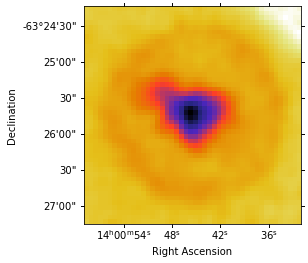

In [6]:
m.sum_over_axes().smooth(1).plot(stretch='log',cmap='CMRmap_r')

(0.3, 10)

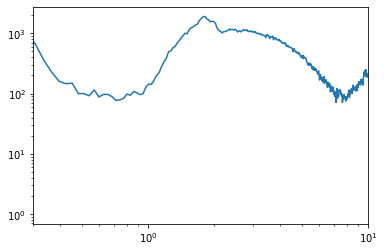

In [7]:
E_cen = m.geom.axes[0].center
plt.loglog(E_cen, m.data.sum(axis=(1,2)) )
plt.xlim(0.3,10)

In [8]:
#outfile='../obs_data/Cube_%s_%spix_XYrebin%s_47blocks.fits'%(name,m.data.shape[2],XYrebin)
outfile='../obs_data/Cube_%s_%spix_XYrebin%s_Erebin%s.fits'%(name,m.data.shape[2],XYrebin,Erebin)

#m.write(outfile,overwrite=True)
#compress(outfile)
